In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [6]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [21]:
from pymono.aux_func import select_image_and_lbl, get_energy, mean_rms

In [46]:
from pymono.plt_funcs import plot_images, plot_energies2, plot_images_ds, plot_loss, plotxyz, histoplot

In [29]:
from pymono.cnn_func import CNN_basic

In [37]:
from pymono.cnn_eval import train_cnn, evaluate_cnn

In [41]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.aux_func import select_image_files, select_image_and_metadata, energy
#from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
#from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [ ]:
#from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
#from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
#from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [ ]:
#from pymono.cnn_plots import plot_images2

In [ ]:
#from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [ ]:
#from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset

In [ ]:
#from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [ ]:
#from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [ ]:
#from pymono.cnn_func import ResNet10

In [ ]:
#from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [ ]:
#from pymono.cnn_func import CNN_basic

In [ ]:
#from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.xdataset import PDataset

In [ ]:
#from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
data_dir = Path(os.environ['DATA'])
crystal = os.path.join(data_dir,"G4Prods/crystalMT", "csiGammasUniformImg")

In [9]:
crystal

'/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg'

# Setup

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- crystalMT simulation
- old data format (x,y,z)

### CNN comparisons: 
- Compare basic, 3x3 and resnet

## Setup

In [10]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]))

In [13]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


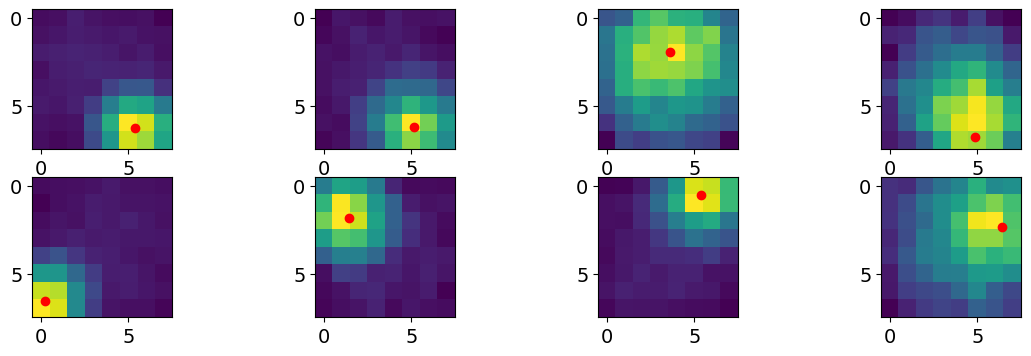

In [15]:
plot_images(imgs, mdata, range(0,8))

In [ ]:
imgs[0]

In [17]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


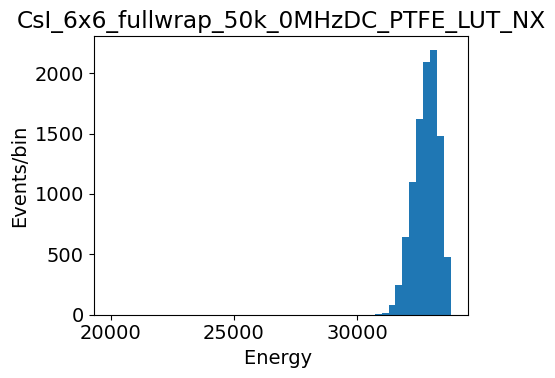

In [20]:
plot_energies2({"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX":energy}, xmin=20000, xmax=max(energy),num_bins = 50)

In [22]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 32811.71 sigma = 1.51 % FWHM = 3.48 %


In [49]:
dfg = pd.read_csv(f"{crystal}/metadata_10.csv", header=0)

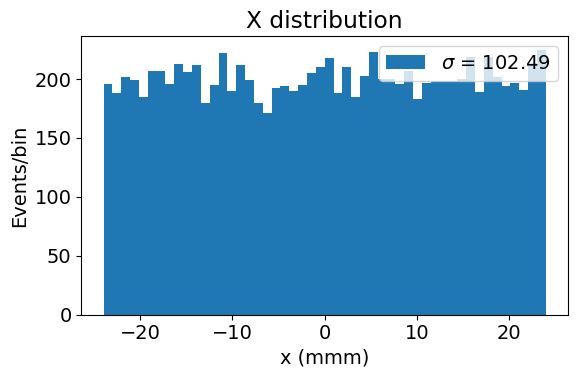

In [50]:
histoplot(dfg["initial_x"], varlbl="x (mmm)", vart="X distribution", num_bins = 50, range=None, figsize=(6, 4))

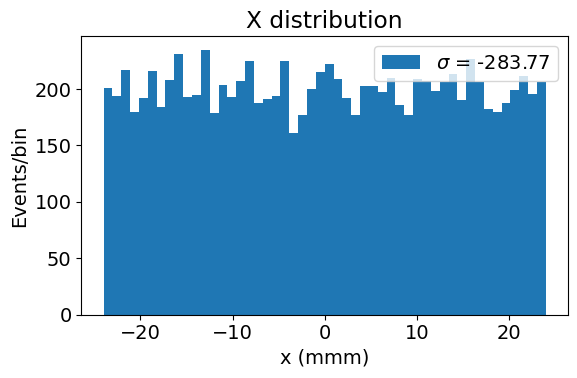

In [51]:
histoplot(dfg["initial_y"], varlbl="y (mmm)", vart="Y distribution", num_bins = 50, range=None, figsize=(6, 4))

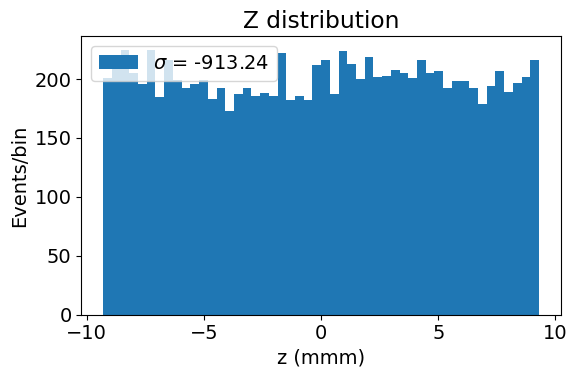

In [52]:
histoplot(dfg["initial_z"], varlbl="z (mmm)", vart="Z distribution", num_bins = 50, range=None, figsize=(6, 4))

## Short run
- 100 files
- No normalization

In [23]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


Variable xyze intoduced to allow two types of format:

1. csv files with format xyz (set xyze == False)
2. csv files with format xyze (set xyze == True)


In [24]:

dataset = MonoDataset(crystal, first_file, last_file, xyze=False)  # No comparison with energy only xyz


Running MonoDataset with norm = False, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [25]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


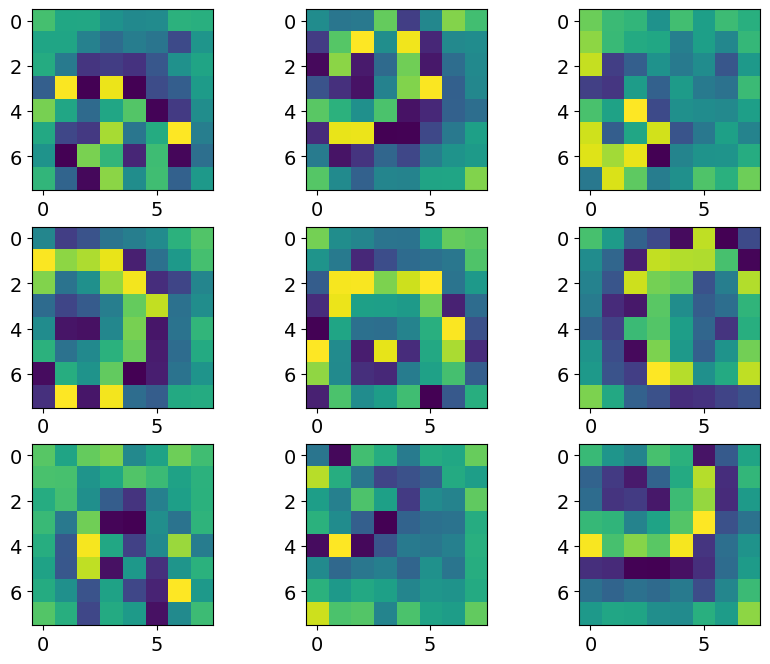

In [27]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [28]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[348., 321., 330., 371., 422., 388., 374., 331.],
        [283., 393., 423., 450., 486., 511., 496., 412.],
        [347., 368., 483., 519., 586., 622., 605., 517.],
        [353., 407., 457., 550., 629., 719., 727., 579.],
        [355., 428., 503., 640., 751., 878., 880., 686.],
        [395., 421., 530., 598., 798., 854., 840., 733.],
        [358., 392., 492., 529., 610., 757., 777., 663.],
        [312., 366., 377., 445., 514., 587., 570., 496.]])


In [30]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [34]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 3])
--- EPOCH 0 AVG TRAIN LOSS: 2.148938914026533
--- EPOCH 0 AVG VAL LOSS: 1.6974761044979096

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 1.2542523780039379
--- EPOCH 1 AVG VAL LOSS: 1.3360767221450807

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 1.1307793663229262
--- EPOCH 2 AVG VAL LOSS: 1.4132296389341354

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 1.0695242955003466
--- EPOCH 3 AVG VAL LOSS: 1.2137471485137938

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 1.0347035528932298
--- EPOCH 4 AVG VAL LOSS: 1.2593310046195985

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 1.0005022247348514
--- 

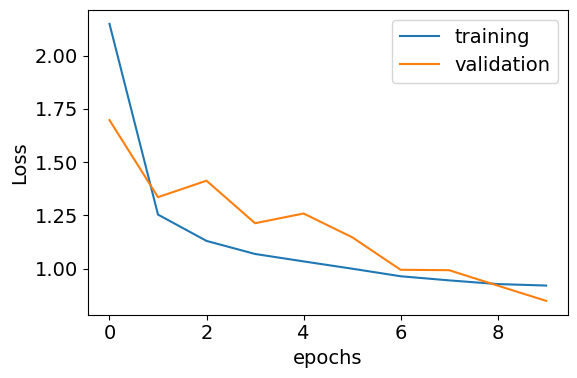

In [36]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [38]:
tdeltas = evaluate_cnn(test_loader, model, device)

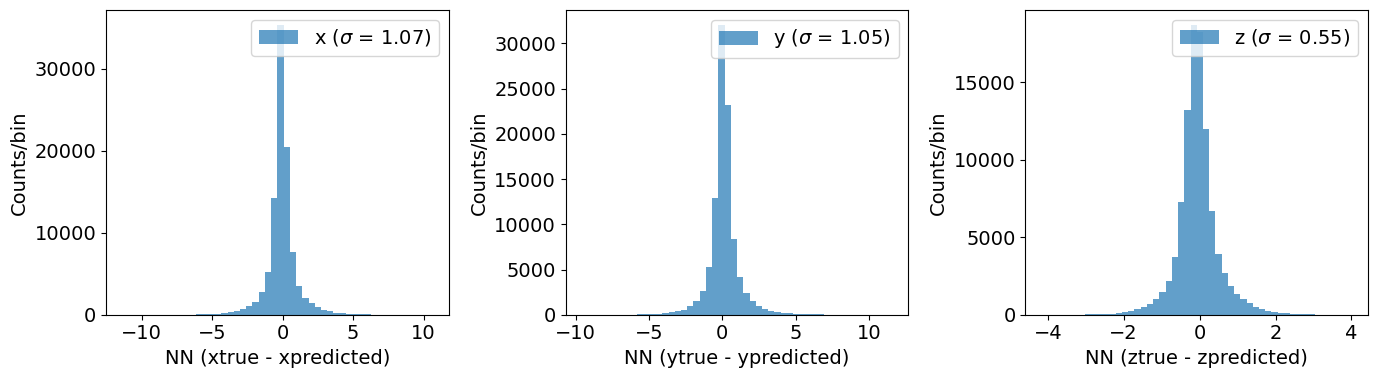

In [40]:
plotxyz(tdeltas, nbins=50)

In [42]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.01, sigma = 0.71, n1  =0.20
2g fit: mu2 = -0.09, sigma = 0.23, n1  =0.80
weighted error: = 0.33
2g fit: mu1 = -0.02, sigma = 1.03, n1  =0.22
2g fit: mu2 = -0.10, sigma = 0.29, n1  =0.78
weighted error: = 0.45
2g fit: mu1 = 0.10, sigma = 0.99, n1  =0.24
2g fit: mu2 = 0.07, sigma = 0.28, n1  =0.76
weighted error: = 0.45


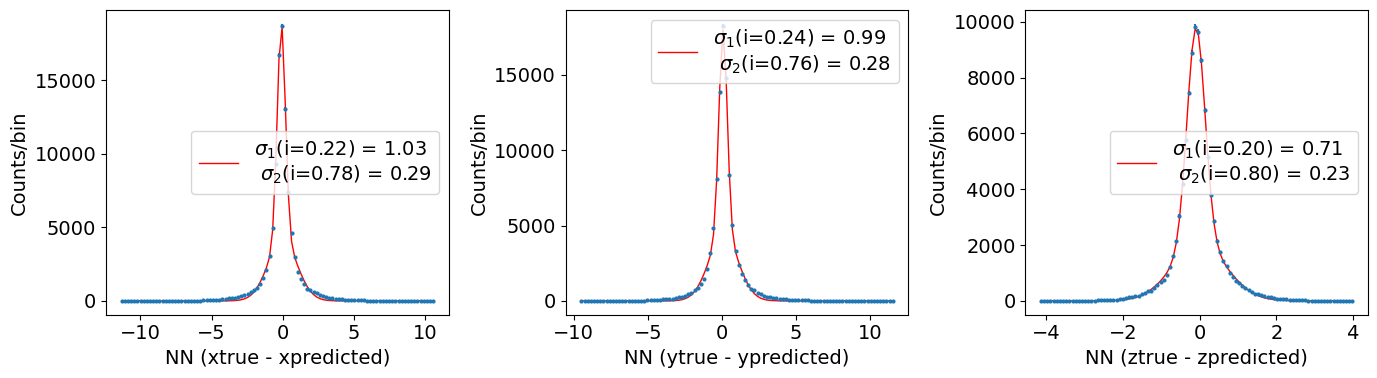

In [43]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))